In [0]:
!pip install tensorflow-datasets

  Could not find a version that satisfies the requirement tensorflow-datasets (from versions: )
No matching distribution found for tensorflow-datasets


In [0]:
import math
import io
import os
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import tree
from tqdm import tqdm
import operator
import pandas as pd
#import keras
#import h5py
#import cPickle

In [0]:
# Go back to top of filesystem
os.chdir('/content')

## Restore Keras Model (Self-contained, do not mix with Tensorflow setup)

In [0]:
# RUN ONCE
# Run Runtime->Reset ALL Runtimes to reset
!git clone https://github.com/mzweilin/EvadeML-Zoo
os.chdir('EvadeML-Zoo')

Cloning into 'EvadeML-Zoo'...
remote: Enumerating objects: 952, done.
remote: Total 952 (delta 0), reused 0 (delta 0), pack-reused 952
Receiving objects: 100% (952/952), 27.54 MiB | 28.23 MiB/s, done.
Resolving deltas: 100% (606/606), done.


In [0]:
!mkdir downloads
!curl -sL https://github.com/mzweilin/EvadeML-Zoo/releases/download/v0.1/downloads.tar.gz | tar xzv -C downloads

MagNet/
MagNet/defensive_models/
MagNet/defensive_models/MNIST_II
MagNet/defensive_models/MNIST_I
MagNet/defensive_models/CIFAR
trained_models/
trained_models/MNIST_pgdtrained.keras_weights.h5
trained_models/MNIST_pgdbase.keras_weights.h5
trained_models/CIFAR-10_carlini.keras_weights.h5
trained_models/MNIST_cleverhans.keras_weights.h5
trained_models/MNIST_cleverhans_adv_trained.keras_weights.h5
trained_models/MNIST_carlini.keras_weights.h5


In [0]:
# Imported from the EvadeML-Zoo project downloaded above
from models import carlini_models
#from models import densenet_models
from keras.utils import np_utils
from keras import backend as K

from keras.datasets import mnist as keras_mnist


Using TensorFlow backend.


In [0]:
K.clear_session()
eml_carlini_cifar_model = carlini_models.carlini_cifar10_model(logits=False, input_range_type=1)
eml_carlini_cifar_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

dataset_name = "CIFAR-10"
model_name = "carlini"
model_weights_fpath = "%s_%s.keras_weights.h5" % (dataset_name, model_name)
model_weights_fpath = os.path.join('downloads/trained_models', model_weights_fpath)
eml_carlini_cifar_model.load_weights(model_weights_fpath)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
eml_carlini_cifar_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
__________

In [0]:
sess = K.get_session()
graph = sess.graph

t_image = graph.get_tensor_by_name('lambda_1_input:0')
t_prediction = graph.get_tensor_by_name('activation_7/Softmax:0')

#Layer selection. Large ones crash runtime when making basic estimator.
#t_layer = graph.get_tensor_by_name('max_pooling2d_1/MaxPool:0') 
#t_layer = tf.reshape(t_layer, [-1, 12544])
#t_layer = graph.get_tensor_by_name('activation_3/Relu:0')
#t_layer = tf.reshape(t_layer, [-1, 18432])
#t_layer = graph.get_tensor_by_name('activation_4/Relu:0')
#t_layer = tf.reshape(t_layer, [-1, 12800])
t_layer = graph.get_tensor_by_name('max_pooling2d_1/MaxPool:0')
t_layer = tf.reshape(t_layer, [-1, 12544])
#t_layer = graph.get_tensor_by_name('flatten_1/Reshape:0')
#t_layer = graph.get_tensor_by_name('activation_5/Relu:0') #Shape: 256
#t_layer = graph.get_tensor_by_name('activation_6/Relu:0') #Shape: 256

In [0]:
graph.get_tensor_by_name('flatten_1/Reshape:0')

<tf.Tensor 'flatten_1/Reshape:0' shape=(?, ?) dtype=float32>

In [0]:
from keras.datasets import cifar10 as keras_cifar
from keras.utils import np_utils

def get_prediction_keras(images, tensor=None, batch_size=100):
  images = np.reshape(images, [len(images), 32, 32, 3])
  if tensor is None:
    return eml_carlini_cifar_model.predict(images, batch_size=100)
  def get_prediction_batch(batch):
    feed = {t_image: np.array(batch)}
    return sess.run(tensor, feed_dict=feed)
  n = len(images)
  if n%batch_size == 0:
    batches = [images[i*batch_size:(i+1)*batch_size] for i in range(int(n/batch_size))]
  else:
    batches = [images[i*batch_size:(i+1)*batch_size] for i in range(int(n/batch_size) +1)]    
  batch_predictions = [get_prediction_batch(b) for b in tqdm(batches)]
  return np.concatenate(tuple(batch_predictions), axis=0)

def get_test_dataset():
  (X_train, y_train), (X_test, y_test) = keras_cifar.load_data()
  X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
  X_test = X_test.astype('float32')
  X_test /= 255
  Y_test = np_utils.to_categorical(y_test, 10)
  del X_train, y_train
  return X_test, Y_test

def get_train_dataset():
  (X_train, y_train), (X_test, y_test) = keras_cifar.load_data()
  X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
  X_train = X_train.astype('float32')
  X_train /= 255
  Y_train = np_utils.to_categorical(y_train, 10)
  del X_test, y_test
  return X_train, Y_train

# t_layer is defined right where the Keras model is defined
def fingerprint_suffix_keras(images, tensor=t_layer):
  print "Getting fingerprint for", tensor.name
  return (get_prediction_keras(images, tensor=tensor)>0.0).astype('int')

In [0]:
# Evaluate model accuracy
test_images, test_labels = get_test_dataset()
test_labels = np.argmax(test_labels, axis=1)
test_predictions = get_prediction_keras(test_images)
test_predictions = np.argmax(test_predictions, axis=1)
print "Test accuracy", 1.0*np.sum(test_predictions == test_labels)/len(test_labels)

170508288/170498071 [==============================] - 21s 0us/step
Test accuracy 0.7796


In [0]:
train_images, train_labels = get_train_dataset()
train_labels = np.argmax(train_labels, axis=1)

train_predictions_all = get_prediction_keras(train_images)
train_predictions = np.argmax(train_predictions_all, axis=1)
print "Predictions computed for all training data"
test_predictions_all = get_prediction_keras(test_images)
test_predictions = np.argmax(test_predictions_all, axis=1)
print "Predictions computed for all test data"

Predictions computed for all training data
Predictions computed for all test data


In [0]:

train_suffixes = fingerprint_suffix_keras(train_images)
print "Suffixes computed for all training data"


test_suffixes = fingerprint_suffix_keras(test_images)
print "Suffixes computed for all test data"


## Set Up Tensorflow Model

In [0]:
# RUN ONCE
# Run Runtime->Reset ALL Runtimes to reset
!git clone https://github.com/tensorflow/models
os.chdir('models/tutorials/image/cifar10/')

In [0]:
#Imported from the Tensorflow deep cnn tutorial scripts, cloned above.
import cifar10
import cifar10_input
# Fix for flags from Burak's Textual Invariants colab.
tf.app.flags.DEFINE_string('f', '', 'kernel')

In [0]:
cifar10.maybe_download_and_extract()

In [0]:
# Get test and train images.
with tf.Graph().as_default():
  train_images_bin, train_labels_bin = cifar10_input.inputs(False, "/tmp/cifar10_data/cifar-10-batches-bin", 50000)
  test_images_bin, test_labels_bin = cifar10_input.inputs(True, "/tmp/cifar10_data/cifar-10-batches-bin", 10000)
  with tf.train.MonitoredSession() as sess:
    test_images, test_labels = sess.run([test_images_bin, test_labels_bin])
    train_images, train_labels = sess.run([train_images_bin, train_labels_bin])

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.FixedLengthRecordDataset`.
Instructions for updating:
Q

In [0]:
BATCH_SIZE = cifar10.FLAGS.batch_size

def create_model(t_images, shape=None):
  # If t_images is None then it creates a placeholder for feeding
  # images. The placeholder has the provided shape.
  #
  # Creates model with images supplied by the t_images tensor.
  if t_images is not None:  
    t_images_pl = tf.placeholder_with_default(t_images, shape=t_images.shape)
  else:
    t_images_pl = tf.placeholder(shape)
  # Build a Graph that computes the logits predictions from the
  # inference model.
  t_logits = cifar10.inference(t_images_pl)
  return t_images_pl, t_logits

def get_prediction(sess, tensor, t_images_pl, images, batch_size=BATCH_SIZE):
  """
  Evaluate given tensor by feeding the provided images.
  TODO: Currently partial batches cannot be evaluated so len(images) must
  be a multiple of batch_size.
  """
  def get_prediction_batch(image_batch):
    feed = {t_images_pl: np.array(image_batch)}
    return sess.run(tensor, feed_dict=feed)
  
  def get_final_batch(images, batch_size):
    pad_value = np.zeros(images[0].shape)
    final_batch = images[int(len(images)/batch_size)*batch_size:]
    pad_size = batch_size-len(final_batch)
    pad = [pad_value for _ in range(pad_size)]
    final_batch = np.concatenate(tuple([final_batch, pad]), axis=0)
    return final_batch, pad_size
  
  n = len(images)
  image_batches = [images[i*batch_size:(i+1)*batch_size] for i in range(int(n/batch_size))]
  padding_size = 0
  if (n % batch_size) != 0:
    # Pad the remainting entries and create an additional batch
    final_batch, pad_size = get_final_batch(images, batch_size)
    image_batches += [final_batch]
  batch_predictions = [get_prediction_batch(b) for b in tqdm(image_batches)]
  # remove padding
  batch_predictions = batch_predictions[:-1] + [batch_predictions[-1][:-pad_size]]
  res = np.concatenate(tuple(batch_predictions), axis=0)
  assert res.shape[0] == images.shape[0]
  return res
  
def train_model(save_steps=500):
  """Train CIFAR-10 for a number of steps."""
  with tf.Graph().as_default():
    t_global_step = tf.train.get_or_create_global_step()

    # Get images and labels for CIFAR-10.
    # Force input pipeline to CPU:0 to avoid operations sometimes ending up on
    # GPU and resulting in a slow down.
    with tf.device('/cpu:0'):
      t_images, t_labels = cifar10.distorted_inputs()

    # Build a Graph that computes the logits predictions from the
    # inference model.
    t_images_pl, t_logits = create_model(t_images)

    # Calculate loss.
    t_loss = cifar10.loss(t_logits, t_labels)

    # Build a Graph that trains the model with one batch of examples and
    # updates the model parameters.
    t_train_op = cifar10.train(t_loss, t_global_step)
    saver_hook = tf.train.CheckpointSaverHook(
      checkpoint_dir='./checkpoints',
      save_secs=None,
      save_steps=save_steps,
      saver=tf.train.Saver(),
      checkpoint_basename='cifar_model.ckpt',
      scaffold=None)
    with tf.train.MonitoredTrainingSession(hooks=[saver_hook]) as sess:
      while not sess.should_stop():
        l, step, _ = sess.run([t_loss, t_global_step, t_train_op])
        if step % save_steps == 0:
          test_logits = get_prediction(sess, t_logits, t_images_pl, test_images)
          test_accuracy = np.mean(np.equal(np.argmax(test_logits, axis=1), test_labels))
          print "Loss at step %d: %f" % (step , l)
          print "Test accuracy at step %d: %f" % (step, test_accuracy)

## Train a new CIFAR10 Tensorflow model, save checkpoint

In [0]:
train_model()

In [0]:
ckpt_path_name = "./checkpoints/cifar_model.ckpt-84000"
from google.colab import files
files.download(ckpt_path_name + '.data-00000-of-00001')
files.download(ckpt_path_name + '.index')
files.download(ckpt_path_name + '.meta')

In [0]:
!ls ./checkpoints

checkpoint
cifar_model.ckpt-1.data-00000-of-00001
cifar_model.ckpt-1.index
cifar_model.ckpt-1.meta
cifar_model.ckpt-400.data-00000-of-00001
cifar_model.ckpt-400.index
cifar_model.ckpt-400.meta
cifar_model.ckpt-600.data-00000-of-00001
cifar_model.ckpt-600.index
cifar_model.ckpt-600.meta
cifar_model.ckpt-65100.data-00000-of-00001
cifar_model.ckpt-65100.index
cifar_model.ckpt-65100.meta
cifar_model.ckpt-65200.data-00000-of-00001
cifar_model.ckpt-65200.index
cifar_model.ckpt-65200.meta
cifar_model.ckpt-65300.data-00000-of-00001
cifar_model.ckpt-65300.index
cifar_model.ckpt-65300.meta
cifar_model.ckpt-65400.data-00000-of-00001
cifar_model.ckpt-65400.index
cifar_model.ckpt-65400.meta
cifar_model.ckpt-700.data-00000-of-00001
cifar_model.ckpt-700.index
cifar_model.ckpt-700.meta
cifar_model.ckpt-800.data-00000-of-00001
cifar_model.ckpt-800.index
cifar_model.ckpt-800.meta
cifar_model.ckpt-83500.data-00000-of-00001
cifar_model.ckpt-83500.index
cifar_model.ckpt-83500.meta
cifar_model.ckpt-84000.da

## Restore Tensorflow model from checkpoint on Github

In [0]:
!mkdir -p ./restored_checkpoints
!wget https://github.com/hayesconverse/sym_convnn/raw/master/CIFAR10_colab_checkpoint/checkpoints_ataly_model/cifar_model.ckpt-84000.index -O ./restored_checkpoints/cifar_model.ckpt.index
!wget https://github.com/hayesconverse/sym_convnn/raw/master/CIFAR10_colab_checkpoint/checkpoints_ataly_model/cifar_model.ckpt-84000.meta -O ./restored_checkpoints/cifar_model.ckpt.meta
!wget https://github.com/hayesconverse/sym_convnn/raw/master/CIFAR10_colab_checkpoint/checkpoints_ataly_model/cifar_model.ckpt-84000.data-00000-of-00001 -O ./restored_checkpoints/cifar_model.ckpt.data-00000-of-00001

In [0]:
tf.reset_default_graph()

# From now on we work with the default graph.
t_images_pl, t_logits = create_model(test_images[:BATCH_SIZE])
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, './restored_checkpoints/cifar_model.ckpt')


INFO:tensorflow:Restoring parameters from ./restored_checkpoints/cifar_model.ckpt


In [0]:
train_predictions_all = get_prediction(sess, t_logits, t_images_pl, train_images)
train_predictions = np.argmax(train_predictions_all, axis=1)
test_predictions_all = get_prediction(sess, t_logits, t_images_pl, test_images)
test_predictions = np.argmax(test_predictions_all, axis=1)

# ACCURACY
print ""
print "Accuracy", np.mean(np.equal(test_predictions, test_labels))

100%|██████████| 79/79 [00:00<00:00, 91.08it/s]


Accuracy 0.8314


## Library for IG Attribution and Conductance

In [0]:
t_fc1 = sess.graph.get_tensor_by_name('local4/local4:0')
t_conv1 = sess.graph.get_tensor_by_name('conv1/conv1:0')
t_label = tf.placeholder(tf.int32)
t_neuron_id = tf.placeholder(tf.int32)
t_grad = tf.gradients(t_logits[:, t_label], t_images_pl)
print t_fc1.shape
print t_conv1.shape
#t_conv2 = sess.graph.get_tensor_by_name('import/h_conv2:0')
t_grad_neuron = tf.gradients(t_logits[:, t_label], t_fc1)[0]
t_grad_conductance = tf.gradients(t_fc1[:,t_neuron_id], t_images_pl, grad_ys=t_grad_neuron[:, t_neuron_id])

(128, 192)
(128, 24, 24, 64)


In [0]:
import copy

def attribute(inp, label, baseline=None, steps=50, use_top_label=False):
  def top_label(inp):
    return np.argmax(get_prediction(sess, t_logits, t_images_pl, [inp])[0])
  if baseline is None:
    baseline = 0*inp
  scaled_inputs = [baseline + (float(i)/steps)*(inp-baseline) for i in range(0, steps)]
  #feed_dict = {W_conv1: convWeightMatrix[0], b_conv1: convBiasMatrix[0], 
  #           W_conv2: convWeightMatrix[1], b_conv2: convBiasMatrix[1], 
  #           W_conv3: convWeightMatrix[2], b_conv3: convBiasMatrix[2], 
  #           W_conv4: convWeightMatrix[3], b_conv4: convBiasMatrix[3], 
  #           W_fc1: denseWeightMatrix[0], b_fc1: denseBiasMatrix[0], 
  #           W_fc2: denseWeightMatrix[1], b_fc2: denseBiasMatrix[1]}
  if use_top_label:
    feed_dict[x] = [inp]
    logits = sess.run(t_logits, feed_dict=feed_dict)[0]
    label = np.argmax(logits)
  feed_dict[x] = scaled_inputs
  feed_dict[t_label] = label
  grads, scores = sess.run([t_grad, t_logits], feed_dict=feed_dict)  # shapes: <steps+1>, <steps+1, inp.shape>
  integrated_gradients = (inp-baseline)*np.average(grads[0], axis=0)  # shape: <inp.shape>
  print "FINAL SCORE", scores[-1][label]
  print "BASELINE SCORE", scores[0][label]
  print "SUM", np.sum(integrated_gradients), "DIFF", scores[-1][label] - scores[0][label]
  return integrated_gradients

def conductance(inp, label, neuron_id=None, baseline=None, steps=50):
  # neuron_id is the id of the neuron in layer t_fc1 through which conductance
  # must be computed. If None, vanilla IG is computed.
  if baseline is None:
    baseline = 0*inp
  scaled_inputs = [baseline + (float(i)/steps)*(inp-baseline) for i in range(0, steps)]
  #feed_dict = {W_conv1: convWeightMatrix[0], b_conv1: convBiasMatrix[0], 
  #           W_conv2: convWeightMatrix[1], b_conv2: convBiasMatrix[1], 
  #           W_conv3: convWeightMatrix[2], b_conv3: convBiasMatrix[2], 
  #           W_conv4: convWeightMatrix[3], b_conv4: convBiasMatrix[3], 
  #           W_fc1: denseWeightMatrix[0], b_fc1: denseBiasMatrix[0], 
  #           W_fc2: denseWeightMatrix[1], b_fc2: denseBiasMatrix[1]}
  feed_dict[x] = scaled_inputs
  feed_dict[t_label] = label
  if neuron_id != None:
    feed_dict[t_neuron_id] = neuron_id
    grads, scores = sess.run([t_grad_conductance, t_logits], feed_dict=feed_dict)  # shapes: <steps+1>, <steps+1, inp.shape>
    integrated_gradients = (inp-baseline)*np.average(grads[0], axis=0)  # shape: <inp.shape>
    return integrated_gradients
  grads, scores = sess.run([t_grad, t_logits], feed_dict=feed_dict)  # shapes: <steps+1>, <steps+1, inp.shape>    
  integrated_gradients = (inp-baseline)*np.average(grads[0], axis=0)  # shape: <inp.shape>
  print "FINAL SCORE", scores[-1][label]
  print "BASELINE SCORE", scores[0][label]
  print "SUM", np.sum(integrated_gradients), "DIFF", scores[-1][label] - scores[0][label]
  return integrated_gradients

## Library for Visualizing Images and Attributions

In [0]:
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import numpy as np
from cStringIO import StringIO

In [0]:
FONT_PATH='/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed.ttf'
IMAGE_SIZE=24

def mnist_to_rgb(mnist_img):
  """
  Transformsn an MNIST image (shape: <784>) to a grayscale
  RGB image (shape: <28,28,3>)
  """
  pixel_array = mnist_img.reshape(IMAGE_SIZE, IMAGE_SIZE)  # shape: 28,28
  rgb_image = np.transpose([pixel_array,pixel_array,pixel_array], axes=[1,2,0])
  return rgb_image

def cifar_to_rgb(cifar_img):
  rgb_image = cifar_img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3) # shape: 32,32,3
  return rgb_image

def pil_img(a):
  '''Returns a PIL image created from the provided RGB array.
  '''
  a = np.uint8(a)
  return PIL.Image.fromarray(a)

def mnist_to_pil_img(inp):
  rgb_inp = 255*mnist_to_rgb(inp)
  vis_inp = pil_img(rgb_inp)
  return vis_inp  

def cifar_to_pil_img(inp):
  rgb_inp = 255*cifar_to_rgb(inp)
  vis_inp = pil_img(rgb_inp) 

def pil_fig(fig):
  # Returns a PIL image obtained from the provided PLT figure.
  buf = io.BytesIO()
  fig.savefig(buf, format='png')
  plt.close(fig)
  buf.seek(0)
  img = PIL.Image.open(buf)
  return img

def show_img(img, fmt='jpeg'):
  '''Displays the provided PIL image
  '''
  f = StringIO()
  img.save(f, fmt)
  display(Image(data=f.getvalue()))
 
def show_mnist_img(mnist_img):
  show_img(pil_img(255*mnist_to_rgb(mnist_img)))
  
def show_cifar_img(cifar_img):
  show_img(pil_img(255*cifar_to_rgb(cifar_img)))
  
def gray_scale(img):
  '''Converts the provided RGB image to gray scale.
  '''
  img = np.average(img, axis=2)
  return np.transpose([img, img, img], axes=[1,2,0])

def normalize(attrs, ptile=99):
  '''Normalize the provided attributions so that they fall between
     -1.0 and 1.0.
  '''
  h = np.percentile(attrs, ptile)
  l = np.percentile(attrs, 100-ptile)
  return np.clip(attrs/max(abs(h), abs(l)), -1.0, 1.0)    

def pil_text(strs, shape, start_h=10, start_w=10, font_size=18, color=(0, 0, 0)):
  # Returns a PIL image with the provided text.
  img = pil_img(255*np.ones(shape))
  draw = PIL.ImageDraw.Draw(img)
  font = PIL.ImageFont.truetype(FONT_PATH, font_size)
  h = start_h
  for s in strs: 
    draw.text((start_w,h), s, fill=color, font=font)
    h = h + 30
  return img

def combine(imgs, horizontal=True):
  # Combines the provided PIL Images horizontally or veritically
  if horizontal:
    w = np.sum([img.size[0]+10 for img in imgs])
    h = np.max([img.size[1] for img in imgs])
  else:
    w = np.max([img.size[0] for img in imgs])
    h = np.sum([img.size[1]+10 for img in imgs])
  final_img = PIL.Image.new('RGB', (w, h), color='white')
  pos = 0
  for img in imgs:
    if horizontal:
      final_img.paste(im=img, box=(pos,0))
      pos = pos+img.size[0]+10
    else:
      final_img.paste(im=img, box=(0,pos))
      pos = pos+img.size[1]+10
  return final_img

def visualize_attrs(img, attrs, ptile=99):
  '''Visaualizes the provided attributions by first aggregating them
    along the color channel to obtain per-pixel attributions and then
    scaling the intensities of the pixels in the original image in
    proportion to absolute value of these attributions.

    The provided image and attributions must of shape (224, 224, 3).
  '''
  if np.sum(attrs) == 0.0:
    # print "Attributions are all ZERO"
    return pil_img(0*img)
  attrs = gray_scale(attrs)
  attrs = abs(attrs)
  attrs = np.clip(attrs/np.percentile(attrs, ptile), 0,1)
  vis = img*attrs
  return pil_img(vis)
  
  
R=np.array([255,0,0])
G=np.array([0,255,0])
B=np.array([0,0,255])
def visualize_attrs2(img, attrs, pos_ch=G, neg_ch=R, ptile=99):
  '''Visaualizes the provided attributions by first aggregating them
     along the color channel and then overlaying the positive attributions
     along pos_ch, and negative attributions along neg_ch.

     The provided image and attributions must of shape (224, 224, 3).
  '''
  if np.sum(attrs) == 0.0:
    # print "Attributions are all ZERO"
    return pil_img(0*img)
  attrs = gray_scale(attrs)
  attrs = normalize(attrs, ptile)   
  pos_attrs = attrs * (attrs >= 0.0)
  neg_attrs = -1.0 * attrs * (attrs < 0.0)
  attrs_mask = pos_attrs*pos_ch + neg_attrs*neg_ch
  vis = 0.3*gray_scale(img) + 0.7*attrs_mask
  return pil_img(vis)

## Extracting Invariant Candidates for Tensorflow Model

In [0]:
t_fc1 = sess.graph.get_tensor_by_name('local4/local4:0')
t_conv1 = sess.graph.get_tensor_by_name('conv1/conv1:0')

AttributeError: ignored

In [0]:
#Test getting suffixes and checking accuracy
t_fc1 = sess.graph.get_tensor_by_name('local4/local4:0')
t_conv1 = sess.graph.get_tensor_by_name('conv1/conv1:0')

T_LAYER = t_fc1
def fingerprint_suffix(images):
  print "Getting fingerprint for", T_LAYER.name
  return (get_prediction(sess, T_LAYER, t_images_pl, images)>0.0).astype('int')

In [0]:
train_suffixes = fingerprint_suffix(train_images)
test_suffixes = fingerprint_suffix(test_images)


  2%|▏         | 6/391 [00:00<00:06, 57.18it/s]

Getting fingerprint for local4/local4:0


 13%|█▎        | 10/79 [00:00<00:00, 98.13it/s]

Getting fingerprint for local4/local4:0


100%|██████████| 79/79 [00:00<00:00, 95.21it/s]


In [0]:
def describe_input(i, training=True):
  if training:
    print "Input", i
    print "Groundtruth", train_labels[i]
    print "Prediction", train_predictions[i]
    print "Fine-grained prediction", 10*train_labels[i] + train_predictions[i]
    show_cifar_img(train_images[i])
  else:
    print "Input", i
    print "Groundtruth", test_labels[i]
    print "Prediction", test_predictions[i]
    print "Fine-grained prediction", 10*test_labels[i] + test_predictions[i]
    show_cifar_img(test_images[i])

## Build the Decision Tree

In [0]:
# Basic decision tree
basic_estimator = tree.DecisionTreeClassifier()
basic_estimator.fit(train_suffixes, train_predictions)

# Evaluate basic_estimator on test data
basic_estimator_acc = (basic_estimator.predict(test_suffixes) == test_labels)
basic_estimator_agreement = (basic_estimator.predict(test_suffixes) == test_predictions)
print "Estimator accuracy", 1.0*np.sum(basic_estimator_acc)/len(test_suffixes)
print "Estimator agreement", 1.0*np.sum(basic_estimator_agreement)/len(test_suffixes)

Estimator accuracy 0.67
Estimator agreement 0.7238


In [0]:
# Fine-grained predictions decision tree
fine_grained_predictions = 10*train_labels + train_predictions
fine_grained_estimator = tree.DecisionTreeClassifier()
fine_grained_estimator.fit(train_suffixes, fine_grained_predictions)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [0]:
# Decision tree per label
def get_relative_predictions(label):
  print "Create relative predictions for label:%d" % label
  res = np.zeros(train_predictions.shape)
  for i in range(len(train_predictions)):
    pred = train_predictions[i]
    gt = cifar_train_labels[i]
    if gt == label and pred == gt:
      res[i] = 0
    elif gt == label and pred != gt:
      res[i] = 1
    else:
      res[i] = 2
  print "Num correct: %d" % np.sum(res == 0)
  print "Num misclassified: %d" % np.sum(res == 1)
  print "Num others: %d" % np.sum(res == 2)
  return res

def get_relative_estimator(label):
  predictions = get_relative_predictions(label)
  print "Creating decision tree for label:%d" % label
  estimator = tree.DecisionTreeClassifier()
  estimator.fit(train_suffixes, predictions)
  return estimator

In [0]:
# SLOW; run only if you want to build relative estimators.
relative_estimators = [None for _ in range(10)]
for i in range(10):
  relative_estimators[i] = get_relative_estimator(i)

## Distillation Analysis for Paper (CAV 2019)

In [0]:
# Run Restore Keras Model and Jump to this place

In [0]:
t_flatten = graph.get_tensor_by_name('flatten_1/Reshape:0') #Shape: 3200
train_suffixes_flatten = fingerprint_suffix_keras(train_images, tensor=t_flatten)
test_suffixes_flatten = fingerprint_suffix_keras(test_images, tensor=t_flatten)

t_dense1 = graph.get_tensor_by_name('activation_5/Relu:0') #Shape: 256
train_suffixes_dense1 = fingerprint_suffix_keras(train_images, tensor=t_dense1)
test_suffixes_dense1 = fingerprint_suffix_keras(test_images, tensor=t_dense1)

t_dense2 = graph.get_tensor_by_name('activation_6/Relu:0') #Shape: 256
train_suffixes_dense2 = fingerprint_suffix_keras(train_images, tensor=t_dense2)
test_suffixes_dense2 = fingerprint_suffix_keras(test_images, tensor=t_dense2)

  2%|▏         | 8/500 [00:00<00:06, 78.72it/s]

Getting fingerprint for flatten_1/Reshape:0


 11%|█         | 11/100 [00:00<00:00, 104.00it/s]

Getting fingerprint for flatten_1/Reshape:0


  2%|▏         | 8/500 [00:00<00:06, 78.64it/s]

Getting fingerprint for activation_5/Relu:0


 10%|█         | 10/100 [00:00<00:00, 98.29it/s]

Getting fingerprint for activation_5/Relu:0


  2%|▏         | 11/500 [00:00<00:04, 100.37it/s]

Getting fingerprint for activation_6/Relu:0


 11%|█         | 11/100 [00:00<00:00, 101.36it/s]

Getting fingerprint for activation_6/Relu:0


100%|██████████| 100/100 [00:01<00:00, 92.99it/s]


In [0]:
def eval_basic_estimator(estimator, suffixes, orig_model_predictions, gt_predictions):
  estimator_predictions = estimator.predict(suffixes)
  acc = (estimator_predictions == gt_predictions)
  agreement = (estimator_predictions == orig_model_predictions)
  print "Estimator accuracy", 1.0*np.sum(acc)/len(suffixes)
  print "Estimator agreement", 1.0*np.sum(agreement)/len(suffixes)

print "Flatten"
basic_estimator_flatten = tree.DecisionTreeClassifier()
basic_estimator_flatten.fit(train_suffixes_flatten, train_predictions)
# Evaluation
eval_basic_estimator(basic_estimator_flatten, test_suffixes_flatten, test_predictions, test_labels)

print "Dense1"
basic_estimator_dense1 = tree.DecisionTreeClassifier()
basic_estimator_dense1.fit(train_suffixes_dense1, train_predictions)
# Evaluation
eval_basic_estimator(basic_estimator_dense1, test_suffixes_dense1, test_predictions, test_labels)

print "Dense2"
basic_estimator_dense2 = tree.DecisionTreeClassifier()
basic_estimator_dense2.fit(train_suffixes_dense2, train_predictions)
# Evaluation
eval_basic_estimator(basic_estimator_dense2, test_suffixes_dense2, test_predictions, test_labels)

Flatten
Estimator accuracy 0.3795
Estimator agreement 0.3888
Dense1
Estimator accuracy 0.6715
Estimator agreement 0.7251
Dense2
Estimator accuracy 0.7057
Estimator agreement 0.7872


In [0]:
def get_basic_estimator_confidence(estimator, suffixes):
  leaf_nodes = estimator.apply(suffixes)
  conf_score = estimator.tree_.n_node_samples[leaf_nodes]
  # check that the leaf is pure
  is_pure = np.array([ len(np.where(v != 0)[0]) == 1 for v in estimator.tree_.value[leaf_nodes][:,0,:]])
  print "Num pure instances", np.sum(is_pure)
  conf_score *= is_pure
  return conf_score

In [0]:
def plot_bars(ax, bar_vals, bar_names, ptiles, baseline_val=None, baseline_label=None, width=0.2):
  ax.set_ylabel("Agreement")
  ax.set_xlabel("Proportion of Examples")
  #ax.set_ylim((min([min(b) for b in bar_vals])-0.05, 1.1))
  # ax.set_title(title)
  # TODO: why 'plt' below and not 'ax'?
  ind = np.arange(len(ptiles))
  ax.set_xticks(ind)
  ax.set_xticklabels(["%d%%"%(100-ptile) for ptile in ptiles])
  if baseline_val != None:
    ax.axhline(y=baseline_val, color='b', linestyle='-', label=baseline_label)
  
  colors = ['red', 'blue', 'yellow', 'green']
  bars = []
  for i, b in enumerate(bar_vals):
    assert len(b) == len(ptiles)
    bars.append(ax.bar(ind+i*width, b, width=width, color=colors[i]))
  ax.legend(bars, bar_names)

In [0]:
import matplotlib.pyplot as plt

def show_confidence_plot(conf_scores, conf_score_names, all_estimator_predictions, orig_model_predictions,  gt_predictions, ptiles):
  def get_acc_trend(score, agreement, ptiles):
    acc_trend = []
    for ptile in ptiles:
      above_ptile = (score >= np.percentile(score, ptile))
      # print np.sum(agreement*above_ptile), np.sum(above_ptile)
      acc_trend.append(1.0*np.sum(agreement*above_ptile)/np.sum(above_ptile))
    return acc_trend   
  orig_correct = (orig_model_predictions == gt_predictions)
  acc_trends = []
  for i, score in enumerate(conf_scores):
    estimator_predictions = all_estimator_predictions[i] 
    agreement = (orig_model_predictions == estimator_predictions)
    acc_trends.append(get_acc_trend(score, agreement, ptiles))
  fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,7))
  plot_bars(
      ax,
      acc_trends,
      conf_score_names,
      ptiles,
  )
  plt.show(fig)

basic_estimator_flatten_predictions = basic_estimator_flatten.predict(test_suffixes_flatten)
conf_score_flatten = get_basic_estimator_confidence(basic_estimator_flatten, test_suffixes_flatten)
basic_estimator_dense1_predictions = basic_estimator_dense1.predict(test_suffixes_dense1)
conf_score_dense1 = get_basic_estimator_confidence(basic_estimator_dense1, test_suffixes_dense1)
basic_estimator_dense2_predictions = basic_estimator_dense2.predict(test_suffixes_dense2)
conf_score_dense2 = get_basic_estimator_confidence(basic_estimator_dense2, test_suffixes_dense2)
prediction_score = test_predictions_all.max(axis=1)

Num pure instances 10000
Num pure instances 10000
Num pure instances 10000


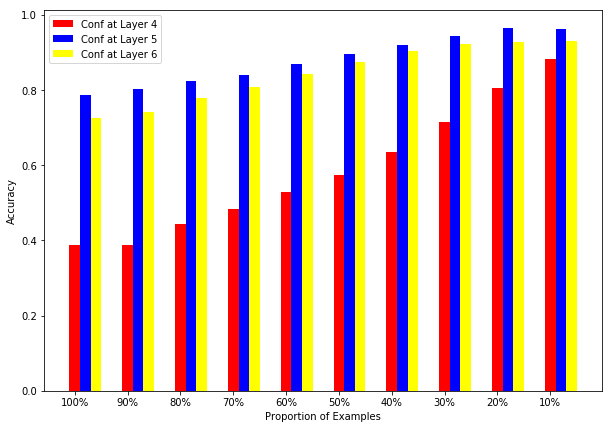

In [0]:
show_confidence_plot(
  [conf_score_flatten, conf_score_dense1, conf_score_dense2],
  ['Conf at Layer 4', 'Conf at Layer 5', 'Conf at Layer 6'],
  [basic_estimator_flatten_predictions, basic_estimator_dense2_predictions, basic_estimator_dense1_predictions],
  test_predictions,
  test_labels,
  10*np.arange(10))

## Confidence Modeling Results for Paper (CAV 2019)

In [0]:
# Run Restore Keras Model and Jump to this place

In [0]:
t_flatten = graph.get_tensor_by_name('flatten_1/Reshape:0') #Shape: 3200
train_suffixes_flatten = fingerprint_suffix_keras(train_images, tensor=t_flatten)
test_suffixes_flatten = fingerprint_suffix_keras(test_images, tensor=t_flatten)

t_dense1 = graph.get_tensor_by_name('activation_5/Relu:0') #Shape: 256
train_suffixes_dense1 = fingerprint_suffix_keras(train_images, tensor=t_dense1)
test_suffixes_dense1 = fingerprint_suffix_keras(test_images, tensor=t_dense1)

t_dense2 = graph.get_tensor_by_name('activation_6/Relu:0') #Shape: 256
train_suffixes_dense2 = fingerprint_suffix_keras(train_images, tensor=t_dense2)
test_suffixes_dense2 = fingerprint_suffix_keras(test_images, tensor=t_dense2)

  2%|▏         | 8/500 [00:00<00:06, 78.76it/s]

Getting fingerprint for flatten_1/Reshape:0


 11%|█         | 11/100 [00:00<00:00, 104.53it/s]

Getting fingerprint for flatten_1/Reshape:0


  2%|▏         | 10/500 [00:00<00:05, 96.41it/s]

Getting fingerprint for activation_5/Relu:0


 11%|█         | 11/100 [00:00<00:00, 101.40it/s]

Getting fingerprint for activation_5/Relu:0


  2%|▏         | 10/500 [00:00<00:05, 96.40it/s]

Getting fingerprint for activation_6/Relu:0


 10%|█         | 10/100 [00:00<00:00, 95.65it/s]

Getting fingerprint for activation_6/Relu:0


100%|██████████| 100/100 [00:01<00:00, 93.32it/s]


In [0]:
def eval_basic_estimator(estimator, suffixes, orig_model_predictions, gt_predictions):
  estimator_predictions = estimator.predict(suffixes)
  acc = (estimator_predictions == gt_predictions)
  agreement = (estimator_predictions == orig_model_predictions)
  print "Estimator accuracy", 1.0*np.sum(acc)/len(suffixes)
  print "Estimator agreement", 1.0*np.sum(agreement)/len(suffixes)

print "Flatten"
basic_estimator_flatten = tree.DecisionTreeClassifier()
basic_estimator_flatten.fit(train_suffixes_flatten, train_predictions)
# Evaluation
eval_basic_estimator(basic_estimator_flatten, test_suffixes_flatten, test_predictions, test_labels)

print "Dense1"
basic_estimator_dense1 = tree.DecisionTreeClassifier()
basic_estimator_dense1.fit(train_suffixes_dense1, train_predictions)
# Evaluation
eval_basic_estimator(basic_estimator_dense1, test_suffixes_dense1, test_predictions, test_labels)

print "Dense2"
basic_estimator_dense2 = tree.DecisionTreeClassifier()
basic_estimator_dense2.fit(train_suffixes_dense2, train_predictions)
# Evaluation
eval_basic_estimator(basic_estimator_dense2, test_suffixes_dense2, test_predictions, test_labels)

Flatten
Estimator accuracy 0.3823
Estimator agreement 0.3918
Dense1
Estimator accuracy 0.6709
Estimator agreement 0.7234
Dense2
Estimator accuracy 0.7051
Estimator agreement 0.7825


In [0]:
def get_basic_estimator_confidence(estimator, suffixes):
  leaf_nodes = estimator.apply(suffixes)
  conf_score = estimator.tree_.n_node_samples[leaf_nodes]
  # check that the leaf is pure
  is_pure = np.array([ len(np.where(v != 0)[0]) == 1 for v in estimator.tree_.value[leaf_nodes][:,0,:]])
  print "Num pure instances", np.sum(is_pure)
  conf_score *= is_pure
  return conf_score

In [0]:
def plot_bars(ax, bar_vals, bar_names, ptiles, baseline_val=None, baseline_label=None, width=0.2):
  ax.set_ylabel("Accuracy")
  ax.set_xlabel("Proportion of Examples")
  #ax.set_ylim((min([min(b) for b in bar_vals])-0.05, 1.1))
  # ax.set_title(title)
  # TODO: why 'plt' below and not 'ax'?
  ind = np.arange(len(ptiles))
  ax.set_xticks(ind)
  ax.set_xticklabels(["%d%%"%(100-ptile) for ptile in ptiles])
  if baseline_val != None:
    ax.axhline(y=baseline_val, color='b', linestyle='-', label=baseline_label)
  
  colors = ['red', 'blue', 'yellow', 'green']
  bars = []
  for i, b in enumerate(bar_vals):
    assert len(b) == len(ptiles)
    bars.append(ax.bar(ind+i*width, b, width=width, color=colors[i]))
  ax.legend(bars, bar_names)

In [0]:
import matplotlib.pyplot as plt

def show_confidence_plot(conf_scores, conf_score_names, orig_model_predictions, gt_predictions, ptiles):
  def get_acc_trend(score, ptiles):
    acc_trend = []
    for ptile in ptiles:
      above_ptile = (score >= np.percentile(score, ptile))
      acc_trend.append(1.0*np.sum(orig_correct*above_ptile)/np.sum(above_ptile))
    return acc_trend   
  orig_correct = (orig_model_predictions == gt_predictions)
  acc_trends = []
  for score in conf_scores:
    acc_trends.append(get_acc_trend(score, ptiles))
  fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,7))
  plot_bars(
      ax,
      acc_trends,
      conf_score_names,
      ptiles,
  )
  plt.show(fig)

conf_score_flatten = get_basic_estimator_confidence(basic_estimator_flatten, test_suffixes_flatten)
conf_score_dense1 = get_basic_estimator_confidence(basic_estimator_dense1, test_suffixes_dense1)
conf_score_dense2 = get_basic_estimator_confidence(basic_estimator_dense2, test_suffixes_dense2)
prediction_score = test_predictions_all.max(axis=1)

Num pure instances 10000
Num pure instances 10000
Num pure instances 10000


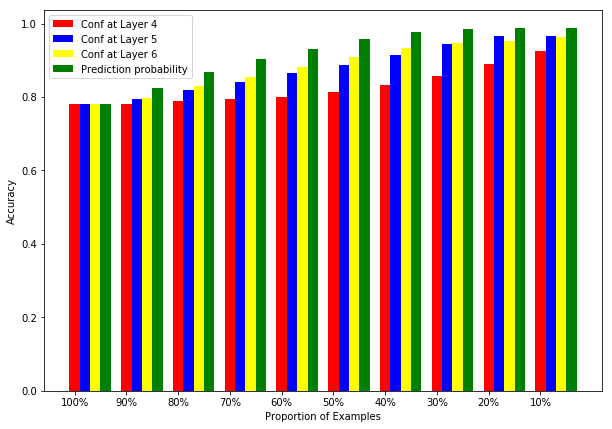

In [0]:
show_confidence_plot(
  [conf_score_flatten, conf_score_dense1, conf_score_dense2, prediction_score],
  ['Conf at Layer 4', 'Conf at Layer 5', 'Conf at Layer 6', 'Prediction probability'],
  test_predictions,
  test_labels,
  10*np.arange(10))

## Examine clusters/invariants

In [0]:
def get_decision_path(estimator, inp):
  # Extract the decision path taken by an input as an ordered list of indices
  # of the neurons that were evaluated.
  # See: http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
  n_nodes = estimator.tree_.node_count
  feature = estimator.tree_.feature

  # First let's retrieve the decision path of each sample. The decision_path
  # method allows to retrieve the node indicator functions. A non zero element of
  # indicator matrix at the position (i, j) indicates that the sample i goes
  # through the node j.
  X_test = [inp]
  node_indicator = estimator.decision_path(X_test)
  # Similarly, we can also have the leaves ids reached by each sample.
  leaf_id = estimator.apply(X_test)
  # Now, it's possible to get the tests that were used to predict a sample or
  # a group of samples. First, let's make it for the sample.
  node_index = node_indicator.indices[node_indicator.indptr[0]:
                                      node_indicator.indptr[1]]
  neuron_ids = []
  for node_id in node_index:
    if leaf_id[0] == node_id:
        continue
    neuron_ids.append(feature[node_id])
  return neuron_ids

def get_suffix_cluster(neuron_ids, neuron_sig):
  # Get the cluster of inputs that such that all inputs in the cluster
  # have provided on/off signature for the provided neurons.
  #
  # The returned cluster is an array of indices (into cifar_train_images).
  return np.where((train_suffixes[:, neuron_ids] == neuron_sig).all(axis=1))[0]

def is_consistent_cluster(cluster, predictions):
  # Check if all inputs within the cluster have the same prediction.
  # 'cluster' is an array of input ids.
  pred = predictions[cluster[0]]
  for i in cluster:
    if predictions[i] != pred:
      return False
  return True

def is_misclassified(i):
  return train_predictions[i] != train_labels[i]

def visualize_conductances(img, label, neuron_ids, only_on=False):
  # Visualize the conductances for the provided image.
  # Args:
  # - img: the provided cifar image
  # - label: prediction label w.r.t. conductance must be computed
  # - neuron_ids: list of neurons indices from the suffix tensor for which
  #    conductances must be computed.
  # - only_on: If True then conductance is computed only for those neurons
  #    that are on for the given image. 
  vis = [cifar_to_pil_img(img)]
  suffix = fingerprint_suffix([img])
  for i, id in enumerate(neuron_ids):
    if only_on and suffix[i] != 1:
      continue  
    igc = conductance(img, label, neuron_id=id)
    # igc = conductances[id]
    vis.append(visualize_attrs2(255*cifar_to_rgb(img), cifar_to_rgb(igc)))
  return combine(vis)

def get_invariant(estimator, ref_id):
  # Returns an invariant found w.r.t. the provided reference input
  # Args
  #  - ref_id: Index (into cifar_train_images) of the reference input
  # Returns:
  #  - cluster: Indices of training inputs that satisfy the invariant
  #  - neuron_id: A list of neurons such that all inputs that agree with
  #    the reference input on the on/off status of these neurons have the
  #    same prediction as the reference input.
  ref_img = train_images[ref_id]
  ref_suffix = train_suffixes[ref_id]
  neuron_ids = get_decision_path(estimator, ref_suffix)
  neuron_sig = ref_suffix[neuron_ids]
  cluster = get_suffix_cluster(neuron_ids, neuron_sig)
  return cluster, neuron_ids, neuron_sig

def get_invariant_generic(estimator, images, suffixes, ref_id):
  # Returns an invariant found w.r.t. the provided reference input
  # Args
  #  - estimator: estimator to use
  #  - images: images to pull from
  #  - suffixes: corresponding suffixes
  #  - ref_id: Index (into data) of the reference input
  # Returns:
  #  - cluster: Indices of training inputs that satisfy the invariant
  #  - neuron_id: A list of neurons such that all inputs that agree with
  #    the reference input on the on/off status of these neurons have the
  #    same prediction as the reference input.
  ref_img = images[ref_id]
  ref_suffix = suffixes[ref_id]
  neuron_ids = get_decision_path(estimator, ref_suffix)
  neuron_sig = ref_suffix[neuron_ids]
  cluster = get_suffix_cluster(neuron_ids, neuron_sig)
  return cluster, neuron_ids, neuron_sig

def get_all_invariants(estimator):
  # Returns a dictionary mapping each decision tree prediction class
  # to a list of invariants. Each invariant is specified as a triple:
  # - neuron ids
  # - neuron signature (for the neuron ids)
  # - number of training samples that hit it
  # The neuron ids and neuron signature can be supplied to get_suffix_cluster
  # to obtain the cluster of training instances that hit the invariant.
  def is_leaf(node):
    return estimator.tree_.children_left[node] == estimator.tree_.children_right[node]

  def left_child(node):
    return estimator.tree_.children_left[node]

  def right_child(node):
    return estimator.tree_.children_right[node]
  
  def get_all_paths_rec(node):
    # Returns a list of triples corresponding to paths
    # in the decision tree. Each triple consists of
    # - neurons encountered along the path
    # - signature along the path
    # - prediction class at the leaf
    # - number of training samples that hit the path
    # The prediction class and number of training samples
    # are set to -1 when the leaf is "impure".
    feature = estimator.tree_.feature
    if is_leaf(node):
      values = estimator.tree_.value[node][0]
      if len(np.where(values != 0)[0]) == 1:
        cl = estimator.classes_[np.where(values != 0)[0][0]]
        nsamples = estimator.tree_.n_node_samples[node]
      else:
        # impure node
        cl = -1
        nsamples = -1
      return [[[], [], cl, nsamples]]
    # If it is not a leaf both left and right childs must exist
    paths = [[[feature[node]] + p[0], [0] + p[1], p[2], p[3]] for p in get_all_paths_rec(left_child(node))]
    paths += [[[feature[node]] + p[0], [1] + p[1], p[2], p[3]] for p in get_all_paths_rec(right_child(node))]
    return paths
  paths =  get_all_paths_rec(0)
  print "Obtained all paths"
  invariants = {}
  for p in tqdm(paths):
    neuron_ids, neuron_sig, cl, nsamples = p
    if cl not in invariants:
      invariants[cl] = []
    # cluster = get_suffix_cluster(neuron_ids, neuron_sig)
    invariants[cl].append([neuron_ids, neuron_sig, nsamples])
  for cl in invariants.keys():
    invariants[cl] = sorted(invariants[cl], key=operator.itemgetter(2), reverse=True)
  return invariants

def describe_cluster(cluster, neuron_ids):
  neuron_sig = train_suffixes[cluster[0]][neuron_ids]
  print "Num neurons in invariant", len(neuron_ids)
  print "Neuron id and signature", zip(neuron_ids, neuron_sig)
  print "Cluster size: ", len(cluster)
  print "Num misclassified", len([i for i in cluster if is_misclassified(i)])

def describe_all_invariants(all_invariants):
  df = []
  for cl, invs in all_invariants.iteritems():
    # Note the number of invariants, and size of the largest invariant cluster
    df.append([cl, sum([inv[2] for inv in invs]), len(invs), len([inv for inv in invs if inv[2]>=10]), invs[0][2]])
  df = pd.DataFrame(df, columns=['Prediction Class', 'Num Instances', 'Num Invariants', 'Num Invariants with cluster size >= 10', 'Size of largest invariant cluster'])
  return df

In [0]:
# Examine cluster/invariants containing a given reference input
# ref_id is the index of the reference input
ref_id =  2
print "### Reference Image ###"
describe_input(ref_id)
print "### Cluster ###"
cluster, neuron_ids, neuron_sig = get_invariant(basic_estimator, ref_id)
describe_cluster(cluster, neuron_ids)

# Visualize  10 inputs in the cluster
for i in cluster[:25]:
  describe_input(i)
  # show_img(visualize_conductances(mnist.train.images[i], train_predictions[i], neuron_ids, only_on=False))

### Reference Image ###


NameError: ignored

In [0]:
b_all_invariants = get_all_invariants(basic_estimator)
df = describe_all_invariants(b_all_invariants)
print "Total num invariants:", df['Num Invariants'].sum()
print "Total num invariants with cluster size >= 10:", df['Num Invariants with cluster size >= 10'].sum()
print df.to_string(index=False)

100%|██████████| 3379/3379 [00:00<00:00, 471601.00it/s]

Obtained all paths
Total num invariants: 3379
Total num invariants with cluster size >= 10: 459
Prediction Class  Num Instances  Num Invariants  Num Invariants with cluster size >= 10  Size of largest invariant cluster
               0           5055             349                                      46                               1929
               1           5086             232                                      27                               3558
               2           5010             480                                      63                                873
               3           5081             473                                      68                               1298
               4           5032             366                                      50                               2056
               5           4956             355                                      52                               1792
               6           4994            

In [0]:
# Get all fine_grained_estimator invariants
fge_all_invariants = get_all_invariants(fine_grained_estimator)
# Print invariant stats
df = describe_all_invariants(fge_all_invariants)
print "Total num invariants:", df['Num Invariants'].sum()
print "Total num invariants with cluster size >= 10:", df['Num Invariants with cluster size >= 10'].sum()
print df.to_string(index=False)



### Analyzing clusters of misclassified inputs

In [0]:
# Examine the cluster for a misclasification (Groundtruth: 4, Prediction: 49)
invs = b_all_invariants[0]
neuron_ids, neuron_sig, _ = invs[0]
cluster = get_suffix_cluster(neuron_ids, neuron_sig)
describe_cluster(cluster, neuron_ids)

# Visualize  10 inputs in the cluster
for i in cluster[:10]:
  describe_input(i)
  # show_img(visualize_conductances(mnist.train.images[i], train_predictions[i], neuron_ids, only_on=False))

## Confidence Modeling

In [0]:
def get_estimator_confidence(estimator, suffixes, estimator_predictions, estimator_conf_labels, min_samples):
  estimator_leaf_nodes = estimator.apply(suffixes)
  # check that the leaf has valid label. (For instance, for a fine grained estimator
  # only labels 00, 11, .. are valid.)
  estimator_conf = [p in estimator_conf_labels for p in estimator_predictions]
  # check that the leaf has a minimum number of samples in its support
  estimator_conf *= estimator.tree_.n_node_samples[estimator_leaf_nodes] >= min_samples
  # check that the leaf is pure
  estimator_pure = np.array([ len(np.where(v != 0)[0]) == 1 for v in estimator.tree_.value[estimator_leaf_nodes][:,0,:]])
  estimator_conf *= estimator_pure
  return estimator_conf

def get_estimator_confidence_by_leaf_visits(
    estimator, suffixes, estimator_predictions,
    estimator_leaf_nodes, estimator_conf_labels):
  # The confidence for each input is the number of samples that visit the same
  # leaf as the input. The exception is inputs that reach impure leaves or leaves
  # with labels outside estimator_conf_labels. For them the confidence is 0. 
  #
  # Compute number of samples that visit the leaves
  estimator_conf = estimator.tree_.n_node_samples[estimator_leaf_nodes]
  # check that the leaf has valid label. (For instance, for a fine grained estimator
  # only labels 00, 11, .. are valid.)
  estimator_conf *= np.array([p in estimator_conf_labels for p in estimator_predictions])
  # check that the leaf is pure
  estimator_conf *= (estimator.tree_.impurity[estimator_leaf_nodes] == 0.0)
  return estimator_conf

def get_confident_accuracy(estimator, suffixes, orig_model_predictions, gt_labels, estimator_conf_labels, min_samples=10):
  """
  Args:
    estimator: the estimator used for confidence modeling
    suffixes: the suffixes of the examples over which we evaluate. Typically this
      would be 'test_suffixes'.
    orig_model_predictions: predictions of the original model for these examples. 
      Typically this would be 'test_predictions'.
    gt_labels: groundtruth labels for these examples. Typically this would be
      mnist.test.labels.
    estimator_conf_labels: prediction labels for the estimator which must be used
      for confidence labels. If the estimator predicts a label outside this set then
      the prediction on the example is not considered "confident". For the basic_estimator
      all labels are fine for confidence modeling. For the fine_grained estimator
      we would want to only use the "pure" labels for confident modeling. For
      instance, 00, 11, ... , for the MNIST fine_grained_estimator.
    min_samples: minimum number of samples for an estimator leaf for it to be
      considered confident
  """
  estimator_predictions = estimator.predict(suffixes)

  # The following are all binary vectors of shape <len(suffixes)>  
  orig_correct = (orig_model_predictions == gt_labels)
  estimator_conf = get_estimator_confidence(estimator, suffixes, estimator_predictions, estimator_conf_labels, min_samples)

  conf_frac = 1.0*np.sum(estimator_conf)/len(gt_labels)
  overall_acc = 1.0*np.sum(orig_correct)/len(gt_labels)
  conf_acc = 1.0*np.sum(orig_correct*estimator_conf)/np.sum(estimator_conf)
 
  return conf_frac, overall_acc, conf_acc

# BASIC_ESTIMATOR
res = get_confident_accuracy(basic_estimator, test_suffixes, test_predictions, test_labels, np.array(range(10)), min_samples = 2500)
conf_frac, overall_acc,  conf_acc = res
print "BASIC ESTIMATOR"
print "Confident fraction", conf_frac
print "Overall accuracy", overall_acc
print "Confident accuracy", conf_acc

BASIC ESTIMATOR
Confident fraction 0.0465
Overall accuracy 0.7796
Confident accuracy 0.956989247312


In [0]:
# FINE_GRAINED_ESTIMATOR
res = get_confident_accuracy(fine_grained_estimator, test_suffixes, test_predictions, test_labels, 10*np.array(range(10))+np.array(range(10)) , min_samples = 250)
conf_frac, overall_acc,  conf_acc = res

print ""
print "FINE GRAINED ESTIMATOR"
print "Confident fraction", conf_frac
print "Overall accuracy", overall_acc
print "Confident accuracy", conf_acc

100%|██████████| 49/49 [00:07<00:00,  6.30it/s]


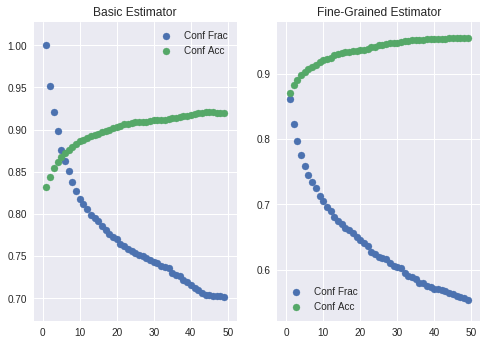

In [0]:
basic_conf_fracs = []
basic_overall_accs = []
basic_conf_accs = []
fg_conf_fracs = []
fg_overall_accs = []
fg_conf_accs = []
max_samples = 50
for i in tqdm(range(1, max_samples)):
  res = get_confident_accuracy(basic_estimator, test_suffixes, test_predictions, test_labels, np.array(range(10)), min_samples = i)
  conf_frac, overall_acc, conf_acc = res
  basic_conf_fracs.append(conf_frac)
  basic_overall_accs.append(overall_acc)
  basic_conf_accs.append(conf_acc)
  res = get_confident_accuracy(fine_grained_estimator, test_suffixes, test_predictions, test_labels, 10*np.array(range(10))+np.array(range(10)), min_samples = i)
  conf_frac, overall_acc,  conf_acc = res
  fg_conf_fracs.append(conf_frac)
  fg_overall_accs.append(overall_acc)
  fg_conf_accs.append(conf_acc)

fig, axs = plt.subplots(1, 2)
axs[0].scatter([range(1, max_samples)], basic_conf_fracs, label='Conf Frac')
#axs[1,0].scatter([range(max_samples)], basic_overall_accs)
axs[0].scatter([range(1, max_samples)], basic_conf_accs, label='Conf Acc')
axs[0].set_title("Basic Estimator")
axs[0].legend()
#axs[0,0].set_title("Basic Confident Fractions")
#axs[1,0].set_title("Basic Overall Accuracies")
#axs[1,0].set_title("Basic Confident Accuracies")

axs[1].scatter([range(1, max_samples)], fg_conf_fracs, label='Conf Frac')
#axs[1,1].scatter([range(max_samples)], fg_overall_accs)
axs[1].scatter([range(1, max_samples)], fg_conf_accs, label='Conf Acc')
axs[1].set_title("Fine-Grained Estimator")
axs[1].legend()
#axs[0,1].set_title("FG Confident Fractions")
#axs[1,1].set_title("FG Overall Accuracies")
#axs[1,1].set_title("FG Confident Accuracies")

plt.subplots_adjust(hspace=0.3)
plt.show()

In [0]:
estimator_predictions = basic_estimator.predict(test_suffixes)
estimator_leaf_nodes = basic_estimator.apply(test_suffixes)

gt = test_labels
estimator_leaf_num_samples = get_estimator_confidence_by_leaf_visits(
    basic_estimator, test_suffixes,
    estimator_predictions, estimator_leaf_nodes, np.array(range(10)))

orig_correct = (test_predictions == gt)
estimator_correct = (estimator_predictions == gt)
estimator_agreement = (estimator_predictions == test_predictions)

min_samples = 500
estimator_conf = estimator_leaf_num_samples > min_samples

print "ORIGINAL MODEL under BASIC ESTIMATOR (min_samples = %d)" % min_samples
print "Overall Acc", 1.0*np.mean(orig_correct)
print "Confident fraction of overall", 1.0*np.mean(estimator_conf)
print "Confident fraction of correct", 1.0*np.sum(estimator_conf*orig_correct)/np.sum(orig_correct)
print "Confident Acc", 1.0*np.sum(orig_correct*estimator_conf)/np.sum(estimator_conf)

print ""
print "BASIC ESTIMATOR"
print "Acc", np.mean(estimator_correct)
print "Agreement", np.mean(estimator_agreement)
print "Estimator Confident Acc", 1.0*np.sum(estimator_correct*estimator_conf)/np.sum(estimator_conf)
print "Estimator Confident Agreement", 1.0*np.sum(estimator_agreement*estimator_conf)/np.sum(estimator_conf)
print "Combined Acc", 1.0*np.mean(orig_correct*(1-estimator_conf)) + 1.0*np.mean(estimator_correct*estimator_conf)

ORIGINAL MODEL under BASIC ESTIMATOR (min_samples = 500)
Overall Acc 0.7796
Confident fraction of overall 0.301
Confident fraction of correct 0.364545920985
Confident Acc 0.944186046512

BASIC ESTIMATOR
Acc 0.6693
Agreement 0.7223
Estimator Confident Acc 0.939534883721
Estimator Confident Agreement 0.97707641196
Combined Acc 0.7782


##Download and run adversarial examples

In [0]:
!mkdir results
!curl -sL https://github.com/mzweilin/EvadeML-Zoo/releases/download/v0.1/results_MNIST_100_317f6_carlini.tar.gz | tar xzv -C results
!curl -sL https://github.com/mzweilin/EvadeML-Zoo/releases/download/v0.1/results_CIFAR-10_100_de671_densenet.tar.gz | tar xzv -C results
!curl -sL https://github.com/mzweilin/EvadeML-Zoo/releases/download/v0.1/results_ImageNet_100_a2749_mobilenet.tar.gz | tar xzv -C results

MNIST_100_317f6_carlini/
MNIST_100_317f6_carlini/adv_examples/
MNIST_100_317f6_carlini/adv_examples/MNIST_100_317f6_carlini_jsma?targeted=next.pickle
MNIST_100_317f6_carlini/adv_examples/MNIST_100_317f6_carlini_carlinili?targeted=next&batch_size=1&max_iterations=1000&confidence=10.pickle
MNIST_100_317f6_carlini/adv_examples/MNIST_100_317f6_carlini_bim?eps=0.3&eps_iter=0.06.pickle
MNIST_100_317f6_carlini/adv_examples/MNIST_100_317f6_carlini_adaptive_carlini_l2?targeted=next&tf_squeezers=median_filter_2_2,binary_filter_0.5&distance_measure=l1&detector_threshold=0.002915.pickle
MNIST_100_317f6_carlini/adv_examples/MNIST_100_317f6_carlini_carlinil0?targeted=next&batch_size=1&max_iterations=1000&confidence=10.pickle
MNIST_100_317f6_carlini/adv_examples/MNIST_100_317f6_carlini_adaptive_carlini_l2?targeted=false&tf_squeezers=median_filter_2_2,binary_filter_0.5&distance_measure=l1&detector_threshold=0.002915.pickle
MNIST_100_317f6_carlini/adv_examples/MNIST_100_317f6_carlini_fgsm?eps=0.3.pickl

In [0]:
import cPickle

#Load adversarial examples
targetNext1Pickle = cPickle.load(open("results/CIFAR-10_100_de671_densenet/adv_examples/CIFAR-10_100_de671_densenet_carlinili?targeted=next&confidence=5.pickle", 'rb'))
targetNext1Data = targetNext1Pickle[0]
targetll1Pickle = cPickle.load(open("results/CIFAR-10_100_de671_densenet/adv_examples/CIFAR-10_100_de671_densenet_carlinili?targeted=ll&confidence=5.pickle", 'rb'))
targetll1Data = targetll1Pickle[0]
targetNext2Pickle = cPickle.load(open("results/CIFAR-10_100_de671_densenet/adv_examples/CIFAR-10_100_de671_densenet_carlinil2?targeted=next&batch_size=100&max_iterations=1000&confidence=5.pickle", 'rb'))
targetNext2Data = targetNext2Pickle[0]
targetll2Pickle = cPickle.load(open("results/CIFAR-10_100_de671_densenet/adv_examples/CIFAR-10_100_de671_densenet_carlinil2?targeted=ll&batch_size=100&max_iterations=1000&confidence=5.pickle", 'rb'))
targetll2Data = targetll2Pickle[0]
targetNext0Pickle = cPickle.load(open("results/CIFAR-10_100_de671_densenet/adv_examples/CIFAR-10_100_de671_densenet_carlinil0?targeted=next&confidence=5.pickle", 'rb'))
targetNext0Data = targetNext0Pickle[0]
targetll0Pickle = cPickle.load(open("results/CIFAR-10_100_de671_densenet/adv_examples/CIFAR-10_100_de671_densenet_carlinil0?targeted=ll&confidence=5.pickle", 'rb'))
targetll0Data = targetll0Pickle[0]
targetNextJsmaPickle = cPickle.load(open("results/CIFAR-10_100_de671_densenet/adv_examples/CIFAR-10_100_de671_densenet_jsma?targeted=next.pickle", 'rb'))
targetNextJsmaData = targetNextJsmaPickle[0]
targetllJsmaPickle = cPickle.load(open("results/CIFAR-10_100_de671_densenet/adv_examples/CIFAR-10_100_de671_densenet_jsma?targeted=ll.pickle", 'rb'))
targetllJsmaData = targetllJsmaPickle[0]
fgsmPickle = cPickle.load(open("results/CIFAR-10_100_de671_densenet/adv_examples/CIFAR-10_100_de671_densenet_fgsm?eps=0.0156.pickle", 'rb'))
fgsmData = fgsmPickle[0]
bimPickle = cPickle.load(open("results/CIFAR-10_100_de671_densenet/adv_examples/CIFAR-10_100_de671_densenet_bim?eps=0.008&eps_iter=0.0012.pickle", 'rb'))
bimData = bimPickle[0]
deepfoolPickle = cPickle.load(open("results/CIFAR-10_100_de671_densenet/adv_examples/CIFAR-10_100_de671_densenet_deepfool?overshoot=10.pickle", 'rb'))
deepfoolData = deepfoolPickle[0]

adversarialData = np.concatenate((targetNext1Data, targetll1Data, targetNext2Data, targetll2Data, targetNext0Data, targetll0Data, targetNextJsmaData, targetllJsmaData, fgsmData, bimData), axis=0)

In [0]:
#Test attack success rate. Meant to work with Keras version of get_prediction
all_attacks = adversarialData
all_attacks_predictions = np.argmax(get_prediction_keras(all_attacks), axis=1)
test_images, test_gt = get_test_dataset()
all_attacks_gt = np.tile(np.argmax(test_gt, axis=1)[:100], 10)
print "Attack succcess rate", 1.0*np.sum(all_attacks_gt != all_attacks_predictions)/len(all_attacks)
successful_attacks = all_attacks[np.where(all_attacks_predictions != all_attacks_gt)[0]]

successful_attacks_suffixes = fingerprint_suffix_keras(successful_attacks)

100%|██████████| 6/6 [00:00<00:00, 48.74it/s]

Attack succcess rate 0.561
Getting fingerprint for activation_5/Relu:0


In [0]:
ind = np.array(range(10000))
np.random.shuffle(ind)
benign_suffixes = test_suffixes[ind]

In [0]:
benign_be_predictions = basic_estimator.predict(benign_suffixes)
benign_be_leaf_nodes = basic_estimator.apply(benign_suffixes)
benign_be_conf = get_estimator_confidence_by_leaf_visits(
    basic_estimator, benign_suffixes, benign_be_predictions, benign_be_leaf_nodes,
    range(10)
)

benign_fge_predictions = fine_grained_estimator.predict(benign_suffixes)
benign_fge_leaf_nodes = fine_grained_estimator.apply(benign_suffixes)
benign_fge_conf = get_estimator_confidence_by_leaf_visits(
    fine_grained_estimator, benign_suffixes, benign_fge_predictions, benign_fge_leaf_nodes,
    11*np.array(range(10))
)

successful_attacks_be_predictions = basic_estimator.predict(successful_attacks_suffixes)
successful_attacks_be_leaf_nodes = basic_estimator.apply(successful_attacks_suffixes)
successful_attacks_be_conf = get_estimator_confidence_by_leaf_visits(
    basic_estimator, successful_attacks_suffixes, successful_attacks_be_predictions,
    successful_attacks_be_leaf_nodes, np.array(range(10)))

successful_attacks_fge_predictions = fine_grained_estimator.predict(successful_attacks_suffixes)
successful_attacks_fge_leaf_nodes = fine_grained_estimator.apply(successful_attacks_suffixes)
successful_attacks_fge_conf = get_estimator_confidence_by_leaf_visits(
    fine_grained_estimator, successful_attacks_suffixes, successful_attacks_fge_predictions,
    successful_attacks_fge_leaf_nodes, 11*np.array(range(10)))

In [0]:
from sklearn import metrics
def get_detection_error_rates(
    benign_conf, attacks_conf, min_samples):
  benign_conf = benign_conf > min_samples
  attacks_conf = attacks_conf > min_samples
  fpr = np.mean(1.0 - benign_conf)
  tpr = np.mean(1.0 - attacks_conf)
  return fpr, tpr

def get_detection_auc(
    benign_conf, attacks_conf):
  fprs = []
  tprs = []
  for min_samples in tqdm(range(1+max(benign_conf.max(), attacks_conf.max()))):
    fpr, tpr = get_detection_error_rates(benign_conf, attacks_conf, min_samples)
    fprs.append(fpr)
    tprs.append(tpr)
  return metrics.auc(fprs, tprs)

In [0]:
min_samples = 10
fpr, tpr = get_detection_error_rates(
  benign_be_conf, successful_attacks_be_conf, min_samples)
print "Basic Estimator (min_samples = %d)" % min_samples
print "FPR (<num test non-confident instances>/ <num test instances>", fpr
print "TPR (<num attack non-confident instances>/ <num attack instances>", tpr

auc = get_detection_auc(
  benign_be_conf, successful_attacks_be_conf)
print "AUC", auc

fpr, tpr = get_detection_error_rates(
  benign_fge_conf, successful_attacks_fge_conf, min_samples)
print "Fine-grained Estimator (min_samples = %d)" % min_samples
print "FPR (<num test non-confident instances>/ <num test instances>", fpr
print "TPR (<num attack non-confident instances>/ <num attack instances>", tpr

auc = get_detection_auc(
  benign_fge_conf, successful_attacks_fge_conf)
print "AUC", auc

 46%|████▌     | 1151/2512 [00:00<00:00, 11508.86it/s]

Basic Estimator (min_samples = 10)
FPR (<num test non-confident instances>/ <num test instances> 0.283
TPR (<num attack non-confident instances>/ <num attack instances> 0.46167557932263814


 51%|█████     | 1201/2346 [00:00<00:00, 12008.44it/s]

AUC 0.6237982174688058
Fine-grained Estimator (min_samples = 10)
FPR (<num test non-confident instances>/ <num test instances> 0.3202
TPR (<num attack non-confident instances>/ <num attack instances> 0.44028520499108736


100%|██████████| 2346/2346 [00:00<00:00, 10750.43it/s]

AUC 0.5891091800356506


In [0]:
test_images1, test_labels1 = get_test_dataset()
all_attacks_gt = np.tile(np.argmax(test_labels1, axis=1)[:100], 10)
all_attacks = adversarialData
adversarial_images = adversarialData

all_attacks_predictions = np.argmax(get_prediction_keras(all_attacks), axis=1)
successful_attacks = all_attacks[np.where(all_attacks_predictions != all_attacks_gt)[0]]
unsuccessful_attacks = all_attacks[np.where(all_attacks_predictions == all_attacks_gt)[0]]
successful_attacks_gt = all_attacks_gt[np.where(all_attacks_predictions != all_attacks_gt)[0]]
unsuccessful_attacks_gt = all_attacks_gt[np.where(all_attacks_predictions == all_attacks_gt)[0]]
print len(successful_attacks)
adversarial_suffixes = fingerprint_suffix_keras(successful_attacks)
adversarial_suffixes = (adversarial_suffixes>0).astype('int')

be_adversarial_predictions = basic_estimator.predict(adversarial_suffixes)
be_adversarial_leaf_nodes = basic_estimator.apply(adversarial_suffixes)
fge_adversarial_predictions = fine_grained_estimator.predict(adversarial_suffixes)
fge_adversarial_leaf_nodes = fine_grained_estimator.apply(adversarial_suffixes)

be_adversarial_conf = get_estimator_confidence_by_leaf_visits(
    basic_estimator, adversarial_suffixes, be_adversarial_predictions, be_adversarial_leaf_nodes, np.array(range(10)))
print "Number of confident adversarial examples from basic estimator", np.sum((be_adversarial_conf)>1000)
fge_adversarial_conf = get_estimator_confidence_by_leaf_visits(
    fine_grained_estimator, adversarial_suffixes, fge_adversarial_predictions, fge_adversarial_leaf_nodes, 10*np.array(range(10))+np.array(range(10)))
print "Number of confident adversarial examples from fine grained estimator", np.sum(fge_adversarial_conf)


100%|██████████| 6/6 [00:00<00:00, 52.19it/s]

561
Getting fingerprint for activation_6/Relu:0
Number of confident adversarial examples from basic estimator 129
Number of confident adversarial examples from fine grained estimator 272276


In [0]:
# Create and run an inference graph for the given adversarial examples, print num conf instances
# This is meant to work with the tensorflow deep cnn stuff
# TABLE OUT OF DATE, IGNORE 
# Fine Grained SS=1 / Fine Grained SS = 10 / Basic SS=10 / Basic SS=5
# targetNext1Data       47 / 5  / 24 / 69
# targetll1Data         46 / 7  / 28 / 67
# targetNext2Data       47 / 6  / 25 / 69
# targetll2Data         47 / 6  / 26 / 69
# targetNext0Data       43 / 6  / 25 / 67
# targetll0Data         43 / 1  / 18 / 65
# targetNextJsmaData    50 / 12 / 48 / 75
# targetllJsmaData      39 / 9  / 49 / 65
# fgsmData              45 / 7  / 27 / 68
# bimData               46 / 5  / 25 / 69
# Totals                330 / 64 / 295 / 683

def preprocess(images):
  # 'images' is a list of images of shape <32, 32, 3> and scaled down to 0 to 1.
  #
  # First scale up to 0 to 255
  images = 255*images 
  centered_data = tf.image.resize_image_with_crop_or_pad(images, 24, 24)
  standardized_data = tf.map_fn(lambda image: tf.image.per_image_standardization(image), centered_data)
  return sess.run(standardized_data)

test_images, test_labels = get_test_dataset()
test_labels = np.argmax(test_labels, axis=1)[:100]
repeated_labels = np.tile(test_labels, 10)

#Select desired data here
adversarial_images = preprocess(adversarialData)
# adversarial_images is what we must feed to our network
adversarial_predictions = np.argmax(get_prediction(sess, t_logits, t_images_pl, adversarial_images), axis=1)
successful_images = adversarial_images[np.array([adversarial_predictions[i] != repeated_labels[i] for i in range(len(adversarial_predictions))])]
print len(successful_images), "successful attacks"
unsuccessful_images = adversarial_images[np.invert(np.array([adversarial_predictions[i] != repeated_labels[i] for i in range(len(adversarial_predictions))]))]
print len(unsuccessful_images), "unsuccessful attacks"
adversarial_suffixes = fingerprint_suffix(unsuccessful_images)
#adversarial_suffixes = fingerprint_suffix(successful_images)
#adversarial_suffixes = fingerprint_suffix(adversarial_images)
adversarial_suffixes = (adversarial_suffixes>0).astype('int')

fge_adversarial_predictions = fine_grained_estimator.predict(adversarial_suffixes)
be_adversarial_predictions = basic_estimator.predict(adversarial_suffixes)

#Adjust confidence threshold here
minsamps = 10
be_adversarial_conf = get_estimator_confidence(basic_estimator, adversarial_suffixes, be_adversarial_predictions, np.array(range(10)), min_samples=minsamps)
print "Number of confident adversarial examples from basic estimator", np.sum(be_adversarial_conf)
fge_adversarial_conf = get_estimator_confidence(fine_grained_estimator, adversarial_suffixes, fge_adversarial_predictions, 10*np.array(range(10))+np.array(range(10)), min_samples=minsamps)
print "Number of confident adversarial examples from fine grained estimator", np.sum(fge_adversarial_conf)


100%|██████████| 4/4 [00:00<00:00, 63.14it/s]


586 successful attacks
414 unsuccessful attacks
Getting fingerprint for local4/local4:0
Number of confident adversarial examples from basic estimator 332
Number of confident adversarial examples from fine grained estimator 259


In [0]:
# Examine invariant clusters that contain adversarial images

from collections import Counter

basic_clusters = [get_invariant_generic(basic_estimator, adversarial_images, adversarial_suffixes, i)[0] for i in tqdm(range(len(adversarial_images)))]
print "\nBasic Estimator:"

basic_images_per_cluster = []
basic_considered_clusters = []
for cluster in basic_clusters:
  ignore = False
  for i in basic_considered_clusters:
    if np.array_equal(cluster, i):
      ignore = True
      break
  if ignore == True:
    continue
  else:
    basic_considered_clusters.append(cluster)
  count = np.sum(np.array([np.array_equal(cluster, i) for i in basic_clusters]).astype(int))
  basic_images_per_cluster.append(count)
basic_cluster_sizes = [len(cluster) for cluster in basic_considered_clusters]
print "Number of unique clusters:", len(basic_cluster_sizes)
print "Max cluster size:", np.amax(basic_cluster_sizes)
print "Clusters larger than 100:", np.sum(np.array([i > 100 for i in basic_cluster_sizes]).astype(int))
print "# adv images in those clusters:"
print np.array(basic_images_per_cluster)[np.array([i > 100 for i in basic_cluster_sizes])]
print "Clusters larger than 500:", np.sum(np.array([i > 500 for i in basic_cluster_sizes]).astype(int))
print "# adv images in those clusters:"
print np.array(basic_images_per_cluster)[np.array([i > 500 for i in basic_cluster_sizes])]
print "max adv images per cluster:", np.amax(basic_images_per_cluster)
print "Adversarial images per cluster:"
print basic_images_per_cluster

fg_clusters = [get_invariant_generic(fine_grained_estimator, adversarial_images, adversarial_suffixes, i)[0] for i in tqdm(range(len(adversarial_images)))] 
print "\nFine-Grained Estimator:"

fg_images_per_cluster = []
fg_considered_clusters = []
for cluster in fg_clusters:
  ignore = False
  for i in fg_considered_clusters:
    if np.array_equal(cluster, i):
      ignore = True
      break
  if ignore == True:
    continue
  else:
    fg_considered_clusters.append(cluster)
  count = np.sum(np.array([np.array_equal(cluster, i) for i in fg_clusters]).astype(int))
  fg_images_per_cluster.append(count)
fg_cluster_sizes = [len(cluster) for cluster in fg_considered_clusters]
print "Number of unique clusters:", len(fg_cluster_sizes)
print "Max cluster size:", np.amax(fg_cluster_sizes)
print "Clusters larger than 100:", np.sum(np.array([i > 100 for i in fg_cluster_sizes]).astype(int))
print "# adv images in those clusters:"
print np.array(fg_images_per_cluster)[np.array([i > 100 for i in fg_cluster_sizes])]
print "Clusters larger than 500:", np.sum(np.array([i > 500 for i in fg_cluster_sizes]).astype(int))
print "# adv images in those clusters:"
print np.array(fg_images_per_cluster)[np.array([i > 500 for i in fg_cluster_sizes])]
print "max adv images per cluster:", np.amax(fg_images_per_cluster)
print "Adversarial images per cluster:"
print fg_images_per_cluster

  0%|          | 0/1000 [00:00<?, ?it/s]


Basic Estimator:
Number of unique clusters: 93
Max cluster size: 3627
Clusters larger than 100: 5
# adv images in those clusters:
[33  6  5  3  3]
Clusters larger than 500: 3
# adv images in those clusters:
[6 5 3]
max adv images per cluster: 122
Adversarial images per cluster:
[88, 52, 38, 116, 26, 46, 22, 57, 39, 14, 42, 5, 33, 12, 4, 122, 10, 6, 6, 18, 7, 29, 15, 11, 8, 6, 4, 8, 7, 4, 8, 6, 3, 5, 2, 4, 1, 2, 3, 10, 5, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 5, 1, 1, 5, 2, 7, 1, 4, 3, 9, 4, 3, 1, 1, 3, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


100%|██████████| 1000/1000 [00:23<00:00, 43.43it/s]



Fine-Grained Estimator:
Number of unique clusters: 154
Max cluster size: 2591
Clusters larger than 100: 1
# adv images in those clusters:
[1]
Clusters larger than 500: 1
# adv images in those clusters:
[1]
max adv images per cluster: 81
Adversarial images per cluster:
[14, 11, 44, 33, 6, 81, 57, 73, 6, 15, 44, 5, 14, 37, 10, 6, 33, 21, 42, 35, 10, 6, 6, 6, 8, 53, 7, 6, 7, 7, 7, 8, 21, 6, 5, 5, 7, 6, 6, 8, 5, 7, 5, 3, 2, 1, 6, 5, 4, 3, 2, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3, 1, 3, 1, 1, 1, 1, 1, 8, 3, 2, 4, 1, 3, 1, 1, 1, 1, 4, 1, 5, 1, 2, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 3, 9, 2, 3, 1, 4, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 4, 1, 3, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### Visualizing the Decision Tree

In [0]:
!apt-get install graphviz
!pip install graphviz
import graphviz

In [0]:
dot_data = tree.export_graphviz(basic_estimator, out_file=None) 
graph = graphviz.Source(dot_data)  
graph 